In [1]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Convert between the PennTreebank tags to simple Wordnet tags


In [2]:
def penn_to_wn(tag):
 
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [3]:
def get_sentiment_score(text):
    total_score = 0
    #print(text)
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        #print(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wn_tag = penn_to_wn(tag)
            if not wn_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()

        total_score = total_score + (sent_score / len(tokens))

    
    return (total_score / len(raw_sentences)) * 100

In [8]:
df =  pd.read_csv("data/small_corpus.csv")
df.shape

(5100, 12)

In [9]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1,NaN,True,"11 22, 2015",A37TWNNTNCY8JV,B0083EYC4A,{'Format:': ' MP3 Music'},rose sisters,ok,One Star,1448150400,NaN
1,1,NaN,True,"01 9, 2015",AZAW12EWF3O6G,B001E9ULJ6,{'Format:': ' MP3 Music'},RVMY,Not worth the price: this digital download was free!,One Star,1420761600,NaN
2,1,NaN,True,"12 14, 2014",A23GI9VA8A2KEK,B004NYNGW8,{'Format:': ' MP3 Music'},teresa,i didn't purchase this,One Star,1418515200,NaN
3,1,NaN,True,"04 1, 2015",A2SC8X1S8P8CFS,B001O03NRM,{'Format:': ' MP3 Music'},VERY BLESSED,Not good,One Star,1427846400,NaN
4,1,NaN,True,"03 28, 2017",AUH0BZW12JM7W,B00SYTMDS6,{'Format:': ' MP3 Music'},A. Goebel,It old and got sick of it fast,Got old,1490659200,NaN


In [10]:
df.dropna(subset=['reviewText'], inplace=True)

In [11]:
df['swn_score'] = df['reviewText'].apply(lambda text : get_sentiment_score(text))

In [13]:
df[['reviewText','swn_score']].sample(5)

,reviewText,swn_score
4405,This song brought back many good memories of my adolescent years.,6.25000
4078,Great music!,0.00000
1727,"This is an amazing song with amazing originality and wonderful, upbeat music. However, I chose the 'explicit' version in error, and found it to have bad language. I would prefer the version that omits bad language, as the content of the 'explicit' destroys the song, in my opinion. I feel the same way about movies that repeat bad language over and over. It totally destroys the whole point of the movie. That's my story and I'm sticking to it.",0.00000
561,"Seemed like the best collection of Beatles songs, but can't give it anything but 1 star because of the packaging. There are 2 discs in cardboard/paper sleeves. I assume to keep them in, there is some kind of sticky stuff ON THE CD!! One, I was able to get it off because it was only on the edge. But the other, the sticky stuff runs across the CD. It is not usable.",-0.15625
4170,"This is a great album to listen to while traveling, at work, sitting around with friends or just working around my home.",1.00000


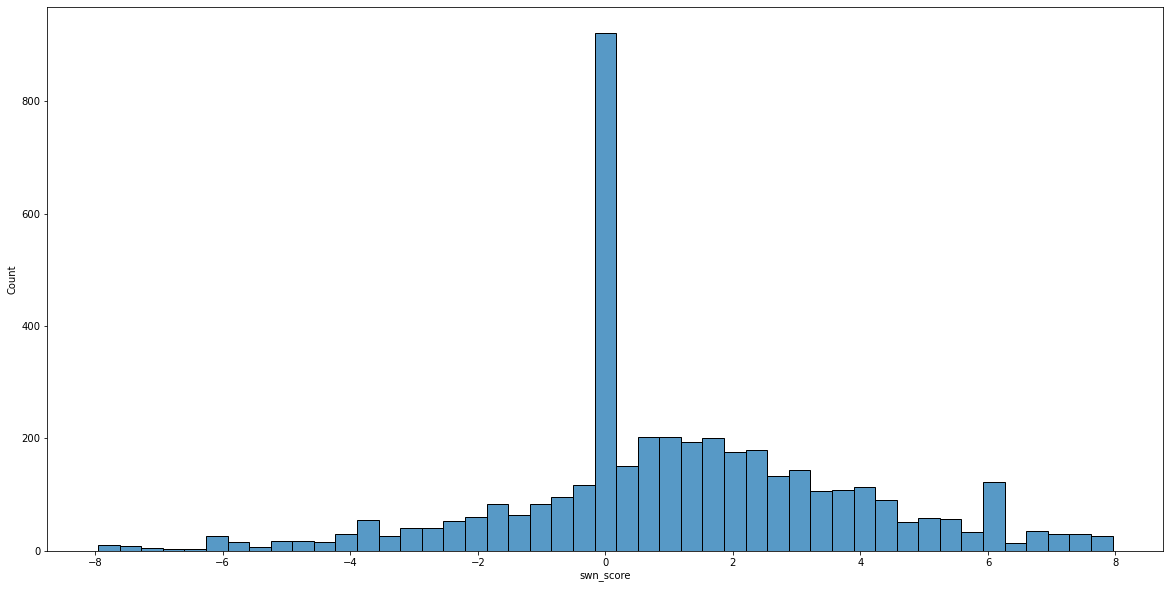

In [15]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='swn_score', data=df.query("swn_score < 8 and swn_score > -8"), ax=ax)
plt.show()

set the score of sentiments

In [16]:
df['swn_sentiment'] = df['swn_score'].apply(lambda x: "positive" if x>1 else ("negative" if x<0.5 else "neutral"))

In [18]:
df['swn_sentiment'].value_counts(dropna=False)

positive    2709
negative    2086
neutral      304
Name: swn_sentiment, dtype: int64

Distribution

<AxesSubplot:xlabel='overall', ylabel='count'>

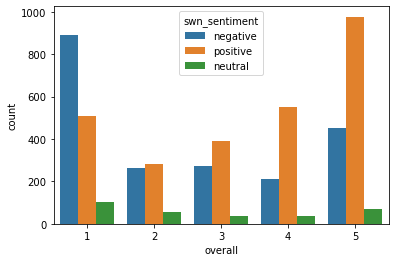

In [19]:
sns.countplot(x='overall', hue='swn_sentiment' ,data = df)

<AxesSubplot:xlabel='swn_sentiment', ylabel='overall'>

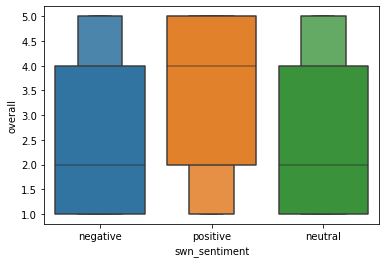

In [20]:
sns.boxenplot(x='swn_sentiment', y='overall', data = df)

In [22]:
df['true_sentiment'] = \
    df['overall'].apply(lambda x: "positive" if x>=4 else ("neutral" if x==3 else "negative"))

In [23]:
y_swn_pred, y_true = df['swn_sentiment'].tolist(), df['true_sentiment'].tolist()

In [24]:
y_swn_pred, y_true = df['swn_sentiment'].tolist(), df['true_sentiment'].tolist()

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_swn_pred)

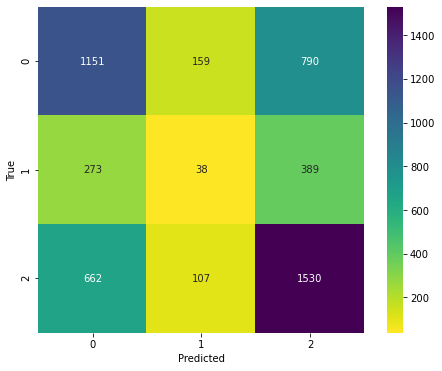

In [26]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [27]:
tp, tn, fp, fn = 1151, 38+389+107+1530, 159+790, 273+662

In [28]:
recall = tp / (tp+fn)
specifity = tn / (tn+fp)
precision = tp/(tp+fp)
f1 = (2*tp) / (2*tp + fp + fn)

In [29]:
print("recall: {}\nprecission: {}\nf1 score: {}".format(recall, precision, f1))

recall: 0.5517737296260786
precission: 0.5480952380952381
f1 score: 0.5499283325370282


In [30]:
tp, tn, fp, fn = 1530, 1151+159+273+38, 389+790, 107+662

In [31]:
recall = tp / (tp+fn)
specifity = tn / (tn+fp)
precision = tp/(tp+fp)
f1 = (2*tp) / (2*tp + fp + fn)

In [32]:
print("recall: {}\nprecission: {}\nf1 score: {}".format(recall, precision, f1))

recall: 0.665506742061766
precission: 0.5647840531561462
f1 score: 0.6110223642172524
